In [8]:
import numpy as np
import xarray as xr

import datetime as dt
import os
import pandas as pd

import matplotlib.pyplot as plt

import altair as alt
alt.data_transformers.enable('json')

from sublimpy import utils
import glob
import pytz
import re
from scipy.signal import welch, csd
from scipy.stats import chi2
from process_fast_data.fast_data_calculate_spectra_nomrd import calculate_mrd_for_df, fast_data_files_to_dataframe
from sublimpy import extrautils

In [2]:
# DATA_DIR = "/storage/elilouis/sublimationofsnow/"
DATA_DIR = "/Users/elischwat/Development/data/sublimationofsnow/"

DATES = pd.Series(['20230418', '20230419'])
DATE_LOCAL = '20230418'

# DATES = pd.Series(['20230409', '20230410'])
# DATE_LOCAL = '20230409'

# Open SOS Fast EC data

In [4]:
sos_file_list = sorted(np.array([
    [f for f in glob.glob(
        os.path.join(DATA_DIR, "sosqc_fast/isfs_sos_qc_geo_tiltcor_hr_v2_**.nc")
    ) if d in f]
    for d in DATES
]).flatten())

fast_df_sos_all_data = fast_data_files_to_dataframe(
    sos_file_list,  #CORRECT THIS
    rotation='none'
)

In [5]:
fast_df_sos_all_data = utils.modify_df_timezone(fast_df_sos_all_data, 'UTC', 'US/Mountain')
fast_df_sos_all_data = fast_df_sos_all_data.set_index('time').loc[DATE_LOCAL]

Isolate short period of time

In [6]:
src = fast_df_sos_all_data.loc[
    '20230418 2034': '20230418 2040'
][[
    'u_3m_c', 'u_5m_c', 'u_10m_c', 'u_15m_c', 'u_20m_c',
    'v_3m_c', 'v_5m_c', 'v_10m_c', 'v_15m_c', 'v_20m_c',
    'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
]]

src_h2o = fast_df_sos_all_data.loc[
    '20230418 2034': '20230418 2040'
][['h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c', 'h2o_20m_c']]

open planar fits and apply them

In [7]:
fits = pd.read_csv(
    "/Users/elischwat/Development/data/sublimationofsnow/monthly_planar_fits.csv",
    sep='\s+'
)
fits = fits.set_index(['month', 'height', 'tower'])
fits = fits.loc[src.index.month[0], :, 'c']

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_44984/928668410.py:3: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+'


In [9]:
(
    u_3m_c , v_3m_c , w_3m_c
) = extrautils.apply_planar_fit(
    src['u_3m_c'], src['v_3m_c'], src['w_3m_c'], fits.loc['3']['a'], fits.loc['3'][['W_f_1', 'W_f_2', 'W_f_3']].values
)
src['u_3m_c'] = u_3m_c
src['v_3m_c'] = v_3m_c
src['w_3m_c'] = w_3m_c


(
    u_5m_c , v_5m_c , w_5m_c
) = extrautils.apply_planar_fit(
    src['u_5m_c'], src['v_5m_c'], src['w_5m_c'], fits.loc['3']['a'], fits.loc['3'][['W_f_1', 'W_f_2', 'W_f_3']].values
)
src['u_5m_c'] = u_5m_c
src['v_5m_c'] = v_5m_c
src['w_5m_c'] = w_5m_c

(
    u_10m_c , v_10m_c , w_10m_c
) = extrautils.apply_planar_fit(
    src['u_10m_c'], src['v_10m_c'], src['w_10m_c'], fits.loc['3']['a'], fits.loc['3'][['W_f_1', 'W_f_2', 'W_f_3']].values
)
src['u_10m_c'] = u_10m_c
src['v_10m_c'] = v_10m_c
src['w_10m_c'] = w_10m_c


(
    u_15m_c , v_15m_c , w_15m_c
) = extrautils.apply_planar_fit(
    src['u_15m_c'], src['v_15m_c'], src['w_15m_c'], fits.loc['3']['a'], fits.loc['3'][['W_f_1', 'W_f_2', 'W_f_3']].values
)
src['u_15m_c'] = u_15m_c
src['v_15m_c'] = v_15m_c
src['w_15m_c'] = w_15m_c


(
    u_20m_c , v_20m_c , w_20m_c
) = extrautils.apply_planar_fit(
    src['u_20m_c'], src['v_20m_c'], src['w_20m_c'], fits.loc['3']['a'], fits.loc['3'][['W_f_1', 'W_f_2', 'W_f_3']].values
)
src['u_20m_c'] = u_20m_c
src['v_20m_c'] = v_20m_c
src['w_20m_c'] = w_20m_c

In [10]:
print(src['w_3m_c'].mean())
print(src['w_5m_c'].mean())
print(src['w_10m_c'].mean())
print(src['w_15m_c'].mean())
print(src['w_20m_c'].mean())

-0.015600892787321201
-0.08662268202315254
-0.05845358357582105
0.013011946106841827
-0.018826625032707375


Open 30-min data for met measurements, calculate absolute humidity

In [12]:
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags360_pf10.parquet"
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')

In [13]:
dry_air_density_table = tidy_df[tidy_df.measurement == 'dry air density'].query("tower == 'c'").query("height >= 3").pivot_table(
    columns='variable',
    index='time',
    values ='value'
)
mixing_ratio_table = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'").query("height >= 3").pivot_table(
    columns='variable',
    index='time',
    values ='value'
)
absolute_humidity_table = mixing_ratio_table.copy()
absolute_humidity_table['abshum_3m_c']  = dry_air_density_table['dryairdensity_3m_c']   * mixing_ratio_table['mixingratio_3m_c']
absolute_humidity_table['abshum_5m_c']  = dry_air_density_table['dryairdensity_5m_c']   * mixing_ratio_table['mixingratio_5m_c']
absolute_humidity_table['abshum_10m_c'] = dry_air_density_table['dryairdensity_10m_c']  * mixing_ratio_table['mixingratio_10m_c']
absolute_humidity_table['abshum_15m_c'] = dry_air_density_table['dryairdensity_15m_c']  * mixing_ratio_table['mixingratio_15m_c']
absolute_humidity_table['abshum_20m_c'] = dry_air_density_table['dryairdensity_20m_c']  * mixing_ratio_table['mixingratio_20m_c']
absolute_humidity_table = absolute_humidity_table[[
    'abshum_3m_c',
    'abshum_5m_c',
    'abshum_10m_c',
    'abshum_15m_c',
    'abshum_20m_c'
]] * 1000

Calibrate the fast gas-analyzer abs humidity values with met-based abs humidity values

In [14]:
h2o_calibrated = fast_df_sos_all_data.loc[
    '20230418 2030': '20230418 2100'
][['h2o_3m_c', 'h2o_5m_c', 'h2o_10m_c', 'h2o_15m_c']]
# calibrate
h2o_calibrated['h2o_3m_c'] = h2o_calibrated['h2o_3m_c'] + absolute_humidity_table.loc['20230418 2030']['abshum_3m_c'] - h2o_calibrated['h2o_3m_c'].mean()
h2o_calibrated['h2o_5m_c'] = h2o_calibrated['h2o_5m_c'] + absolute_humidity_table.loc['20230418 2030']['abshum_5m_c'] - h2o_calibrated['h2o_5m_c'].mean()
h2o_calibrated['h2o_10m_c'] = h2o_calibrated['h2o_10m_c'] + absolute_humidity_table.loc['20230418 2030']['abshum_10m_c'] - h2o_calibrated['h2o_10m_c'].mean()
h2o_calibrated['h2o_15m_c'] = h2o_calibrated['h2o_15m_c'] + absolute_humidity_table.loc['20230418 2030']['abshum_15m_c'] - h2o_calibrated['h2o_15m_c'].mean()

Apply offsets to `w` variables for plotting

In [15]:
src['w_3m_c']   = src['w_3m_c'] + 0
src['w_5m_c']   = src['w_5m_c'] + 3
src['w_10m_c']  = src['w_10m_c'] + 6
src['w_15m_c']  = src['w_15m_c'] + 9
src['w_20m_c']  = src['w_20m_c'] + 12

Plot `w` and abs humidity

<Axes: xlabel='time'>

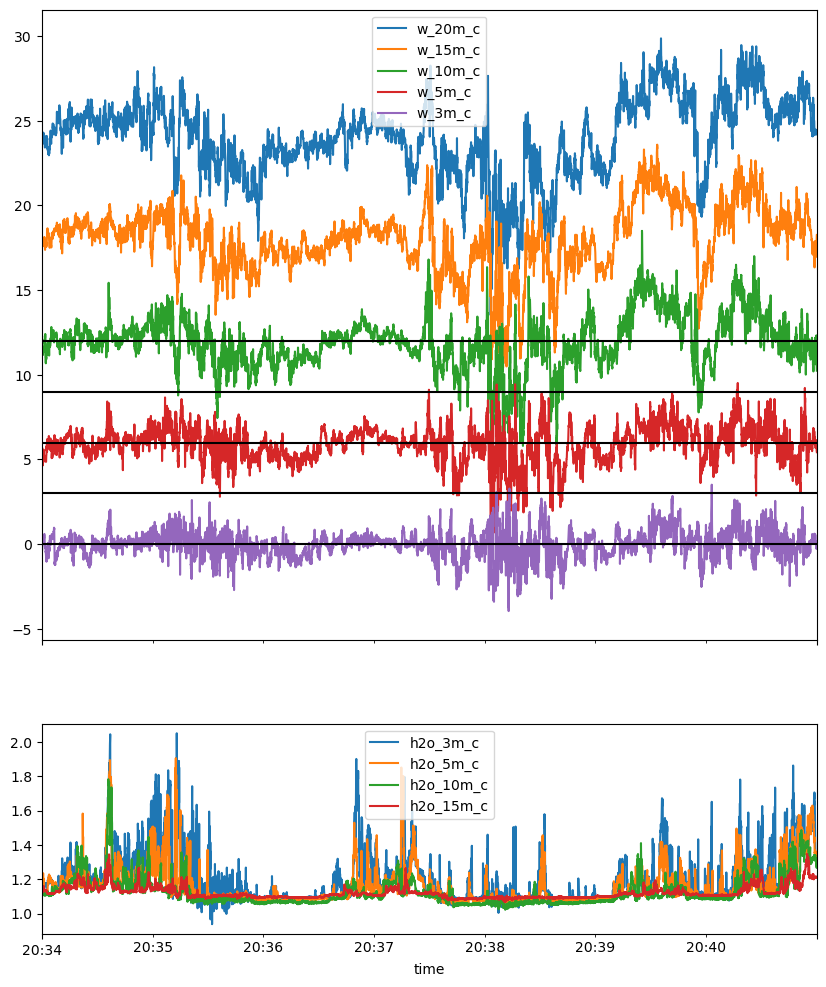

In [16]:
fig, axes = plt.subplots(2,1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
src[
    ['w_20m_c', 'w_15m_c', 'w_10m_c', 'w_5m_c', 'w_3m_c']
].plot(ax=axes[0])
for h in [0, 3, 6, 9, 12]:
    axes[0].axhline(h, color='k')
src_h2o_copy = src_h2o.copy()
src_h2o_copy['h2o_5m_c']     = src_h2o_copy['h2o_5m_c']
src_h2o_copy['h2o_10m_c']    = src_h2o_copy['h2o_10m_c'] - 0.02
src_h2o_copy['h2o_15m_c']    = src_h2o_copy['h2o_15m_c'] + 0.08
h2o_calibrated.loc[
    '20230418 2034': '20230418 2040'
].plot(ax=axes[1])